In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use("ggplot")

In [2]:
import string

In [3]:
df1 = pd.read_csv("data/result/final/train2.tsv", sep="\t")
df2 = pd.read_csv("data/result/final/test2.tsv", sep="\t")
df3 = pd.read_csv("data/result/final/val2.tsv", sep="\t")
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

In [4]:
df.head(2)

,json_id,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,...,sentiment,question,grammar_errors,ratio_of_capital_letters,curse,emotion,gibberish,offensiveness,political_bias,articles
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,negative,not_question,1,3.66,non-curse,disgust,mild gibberish,non-offensive,CENTER,The recent statement from the Annies List poli...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,neutral,question,1,4.26,non-curse,neutral,clean,non-offensive,RIGHT,"The era of coal's dominance is waning, a reali..."


# Data preparation

In [5]:
df[["statement", "justification"]] = df[["statement", "justification"]].astype(str)

## Add statement and justification length information

In [6]:
df["statement_len"] = df["statement"].apply(len)
df["justification_len"] = df["justification"].apply(len)
df["statement_wc"] = df["statement"].apply(lambda x: len(x.split(" ")))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   json_id                   12836 non-null  object 
 1   label                     12836 non-null  object 
 2   statement                 12836 non-null  object 
 3   subject                   12836 non-null  object 
 4   speaker                   12836 non-null  object 
 5   job_title                 9260 non-null   object 
 6   state                     10082 non-null  object 
 7   party_affiliation         12836 non-null  object 
 8   barely_true_counts        12836 non-null  float64
 9   false_counts              12836 non-null  float64
 10  half_true_counts          12836 non-null  float64
 11  mostly_true_counts        12836 non-null  float64
 12  pants_on_fire_counts      12836 non-null  float64
 13  context                   12707 non-null  object 
 14  justif

In [8]:
df = df.drop(["json_id"], axis=1)

In [9]:
pd.set_option('display.max_columns', 200)
df.head(2)

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,justification,sentiment,question,grammar_errors,ratio_of_capital_letters,curse,emotion,gibberish,offensiveness,political_bias,articles,statement_len,justification_len,statement_wc
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,negative,not_question,1,3.66,non-curse,disgust,mild gibberish,non-offensive,CENTER,The recent statement from the Annies List poli...,82,248,11
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",neutral,question,1,4.26,non-curse,neutral,clean,non-offensive,RIGHT,"The era of coal's dominance is waning, a reali...",141,637,24


## Add two-way label

In [10]:
df["bin_label"] = df["label"].apply(lambda x: "true" if x in ["half-true", "mostly-true", "true"] else "false")

## Label as a score

In [11]:
score = {
    "pants-fire": -3,
    "false": -2,
    "barely-true": -1,
    "half-true": 1,
    "mostly-true": 2,
    "true": 3
}
df["label_score"] = df["label"].apply(lambda x: score[x])

In [12]:
df.describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,grammar_errors,ratio_of_capital_letters,statement_len,justification_len,statement_wc,label_score
count,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000
mean,11.595980,13.369975,17.218838,16.526955,6.246261,0.381505,3.685870,106.286460,426.692350,17.914693,0.271035
std,18.996727,24.150879,35.910604,36.225691,16.162788,0.671460,2.684403,45.013247,309.836223,7.748308,2.007545
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,3.000000,2.000000,-3.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.890000,73.000000,272.000000,12.000000,-2.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,0.000000,3.170000,99.000000,395.000000,17.000000,1.000000
75%,12.000000,15.000000,13.000000,12.000000,5.000000,1.000000,4.760000,133.000000,537.000000,22.000000,2.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000,7.000000,82.140000,395.000000,9394.000000,66.000000,3.000000


In [13]:
# Delete row with 13 grammar errors because it wos corrupted
df = df[df["grammar_errors"] != 13]

In [14]:
df['curse'].unique()

array(['non-curse'], dtype=object)

In [15]:
# Change values in curse column and fill null values
df["curse"] = df["curse"].fillna("No")
df["curse"] = df["curse"].replace("Curse", "Yes")

## Feature understanding

<Axes: title={'center': 'Number of statements classified as curse'}, xlabel='curse'>

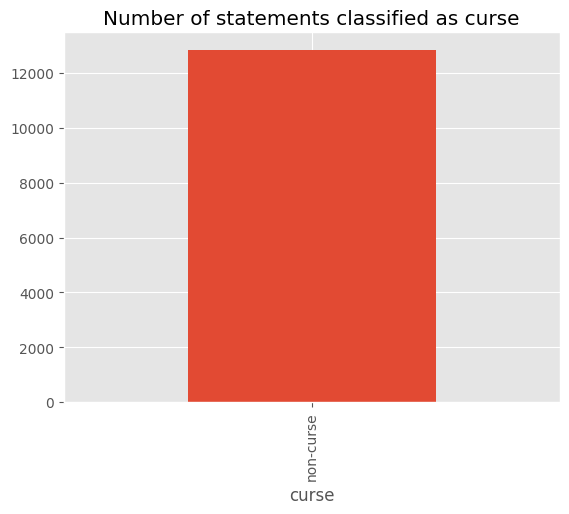

In [16]:
df["curse"].value_counts().plot(kind="bar", title="Number of statements classified as curse")

<Axes: title={'center': 'Distribution of capital letters ratio'}, xlabel='ratio_of_capital_letters'>

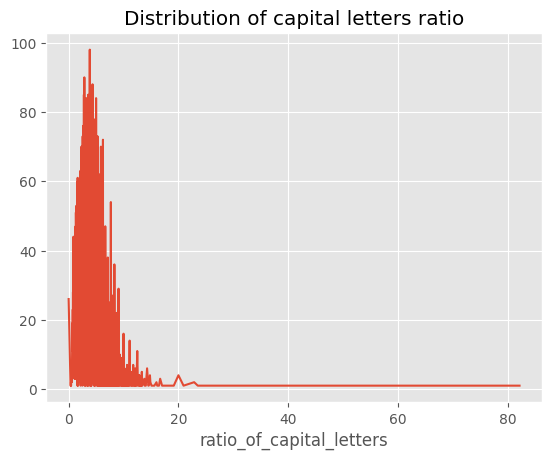

In [17]:
df["ratio_of_capital_letters"].value_counts() \
    .sort_index(ascending=True) \
    .plot(title="Distribution of capital letters ratio")

<Axes: title={'center': 'Distribution of capital letters ratio'}, xlabel='ratio_of_capital_letters'>

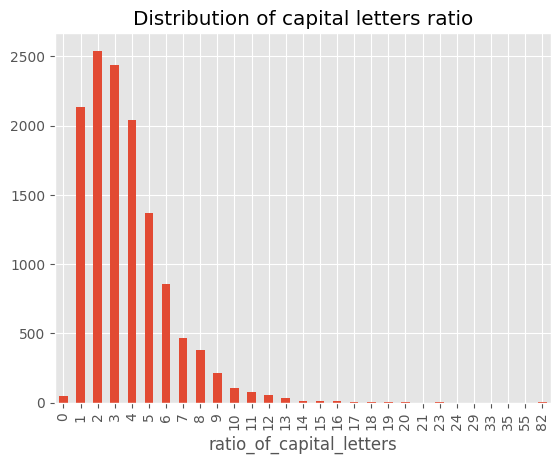

In [18]:
df["ratio_of_capital_letters"].apply(lambda x: round(x))\
    .value_counts() \
    .sort_index(ascending=True) \
    .plot(kind='bar', title="Distribution of capital letters ratio")

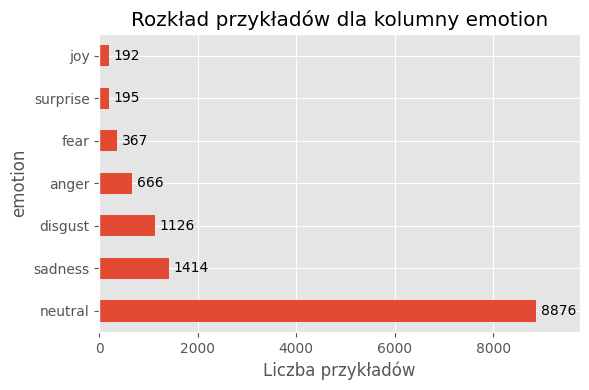

In [19]:
counts = df["emotion"].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

ax = counts.plot(kind="barh", ax=ax, title="Rozkład przykładów dla kolumny emotion")
ax.set_xlabel("Liczba przykładów")

ax.set_xlim(0, max(counts) * 1.1)

# Dodawanie liczbowych etykiet do pasków
for i, (value, count) in enumerate(zip(counts.index, counts.values)):
    ax.text(count + max(counts) * 0.01, i, str(count), va='center')

plt.tight_layout()
plt.show()

# df["gibberish"].value_counts().plot(kind="bar", title="Number of gibberish values")

In [20]:
df["offensiveness"].value_counts()

offensiveness
non-offensive    12552
offensive          284
Name: count, dtype: int64

<Axes: title={'center': 'Number of offensive statements'}, xlabel='offensiveness'>

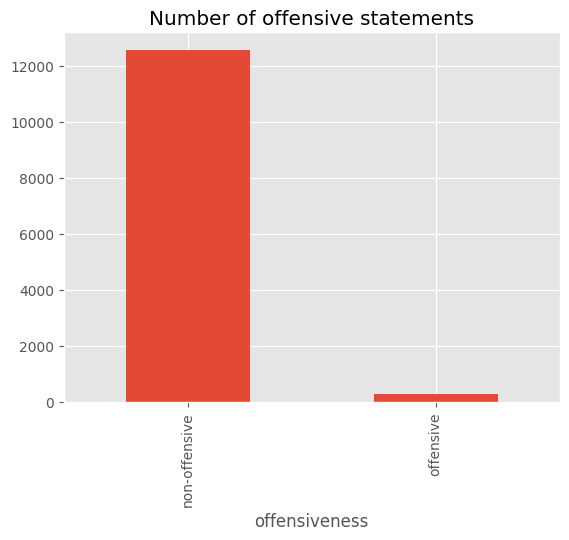

In [21]:
df["offensiveness"].value_counts().plot(kind="bar", title="Number of offensive statements")

In [22]:
df["political_bias"].value_counts()

political_bias
RIGHT     8477
CENTER    2416
LEFT      1943
Name: count, dtype: int64

<Axes: title={'center': 'Political bias distribution'}, xlabel='political_bias'>

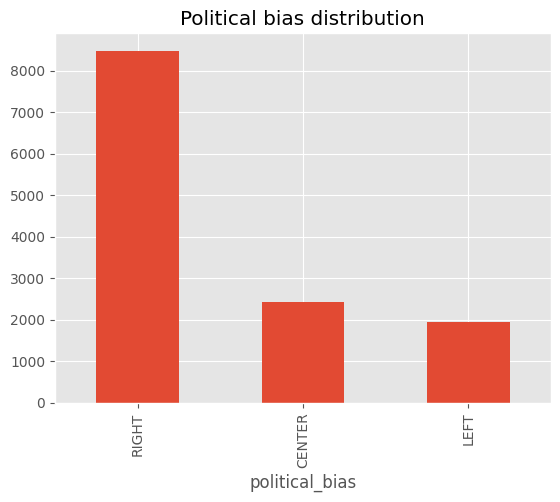

In [23]:
df["political_bias"].value_counts().plot(kind="bar", title="Political bias distribution")

<Axes: title={'center': 'Statement length'}, xlabel='statement_wc'>

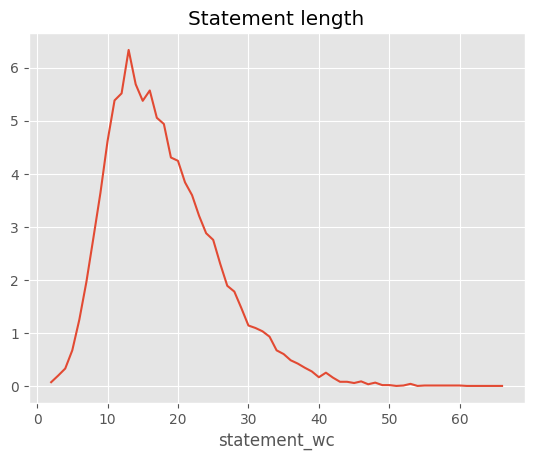

In [24]:
(df["statement_wc"].value_counts(normalize=True) * 100) \
.sort_index(ascending=True) \
.plot(title="Statement length")

<Axes: title={'center': 'Party affiliation'}, ylabel='party_affiliation'>

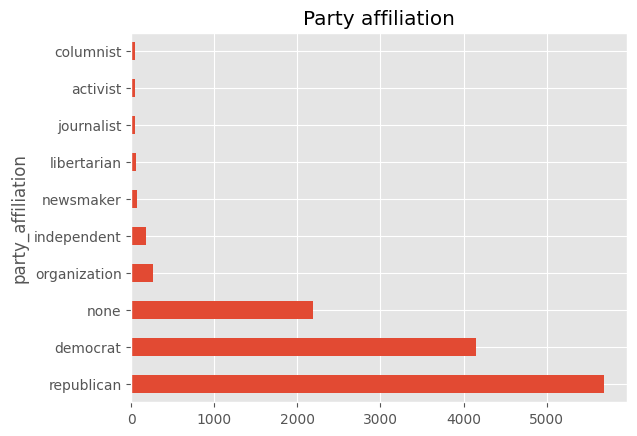

In [25]:
df["party_affiliation"].value_counts().head(10) \
.plot(kind="barh", title="Party affiliation")

## Feature relationship

In [26]:
pd.set_option('display.max_colwidth', 30)

df.head(2)

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,justification,sentiment,question,grammar_errors,ratio_of_capital_letters,curse,emotion,gibberish,offensiveness,political_bias,articles,statement_len,justification_len,statement_wc,bin_label,label_score
0,false,Says the Annies List polit...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he f...,negative,not_question,1,3.66,non-curse,disgust,mild gibberish,non-offensive,CENTER,The recent statement from ...,82,248,11,false,-2
1,half-true,When did the decline of co...,"energy,history,job-accompl...",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,Surovell said the decline ...,neutral,question,1,4.26,non-curse,neutral,clean,non-offensive,RIGHT,The era of coal's dominanc...,141,637,24,true,1


In [27]:
df[["label_score", "ratio_of_capital_letters", "statement_len"]].corr()

,label_score,ratio_of_capital_letters,statement_len
label_score,1.000000,-0.108659,0.045139
ratio_of_capital_letters,-0.108659,1.000000,-0.257531
statement_len,0.045139,-0.257531,1.000000


# From the above data we can conclude that "statement_length" and "ratio_of_capital_letters" do not give much information about the label. A correlation of -0.26 is insufficient.

In [28]:
#curse_vs_label = df.groupby(['curse', 'label_score']).size().reset_index(name='count')
#curse_vs_label = curse_vs_label[curse_vs_label["curse"] == "Yes"]
#curse_vs_label["num_of_labels"] = df.groupby('label_score').size().values
#curse_vs_label["utility_rate"] = curse_vs_label["count"] / curse_vs_label["num_of_labels"] * 100

#print(curse_vs_label)

#curse_vs_label[curse_vs_label["curse"] == "Yes"] \
#.plot(kind="bar", x='label_score', y='utility_rate', title="Number of labels when curse is 'Yes'")

In [29]:
#curse_vs_label = df.groupby(['curse', 'bin_label']).size().reset_index(name='count')
#curse_vs_label = curse_vs_label[curse_vs_label["curse"] == "Yes"]
#curse_vs_label["num_of_labels"] = df.groupby('bin_label').size().values
#curse_vs_label["utility_rate"] = curse_vs_label["count"] / curse_vs_label["num_of_labels"] * 100

#print(curse_vs_label)

#curse_vs_label[curse_vs_label["curse"] == "Yes"] \
#.plot(kind="bar", x='bin_label', y='utility_rate', title="Number of binary labels when curse is 'Yes'")

# From the above data, we can conclude that the column "curse" is quite useful for predicting the label of the statement. The importance of this column increases in binary classification.

In [30]:
custom_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]

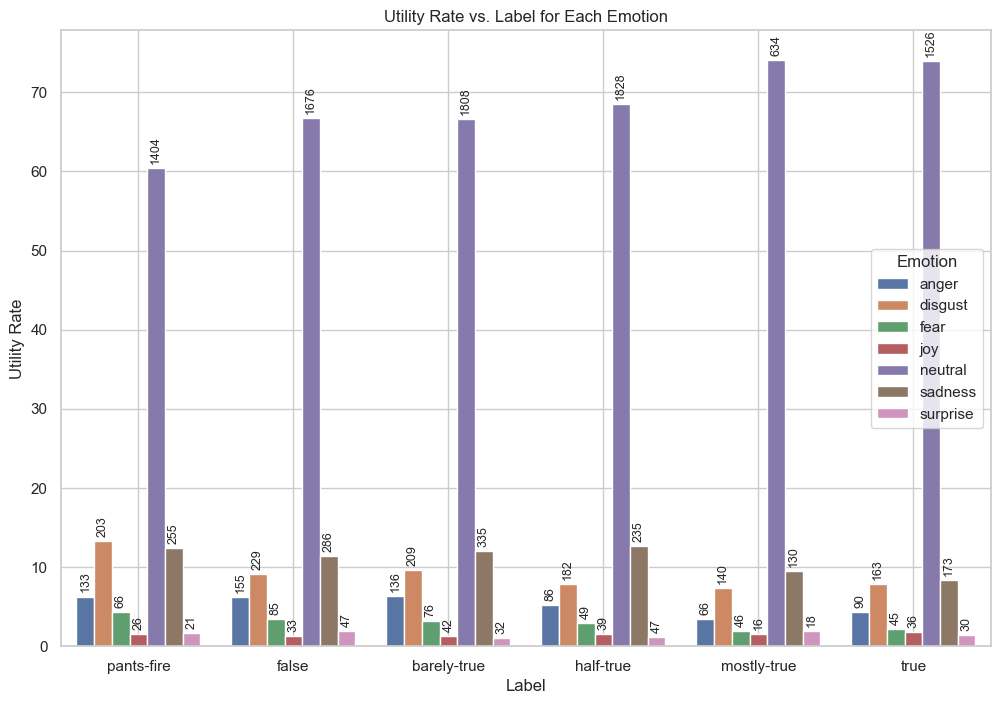

In [31]:
emotion_df = df.groupby(['emotion', 'label']).size().reset_index(name='count')
num_of_labels = df.groupby('label').size()

emotion_df["num_of_labels"] = emotion_df["label"].map(num_of_labels)
emotion_df["utility_rate"] = emotion_df["count"] / emotion_df["num_of_labels"] * 100
#print(emotion_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.barplot(x="label", y="utility_rate", hue="emotion", data=emotion_df, order=custom_order)

# Dodawanie wartości pionowo i jako 'count'
for i, bar in enumerate(ax.patches):
    if emotion_df.shape[0] <= i:
        break
    height = bar.get_height()
    # Pobierz odpowiadający count z DataFrame
    count = emotion_df.iloc[i]["count"]
    
    if height > 0:
        ax.annotate(
            str(count),
            (bar.get_x() + bar.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=9,
            rotation=90,
            xytext=(0, 3),
            textcoords='offset points'
        )

plt.title('Utility Rate vs. Label for Each Emotion')
plt.xlabel('Label')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

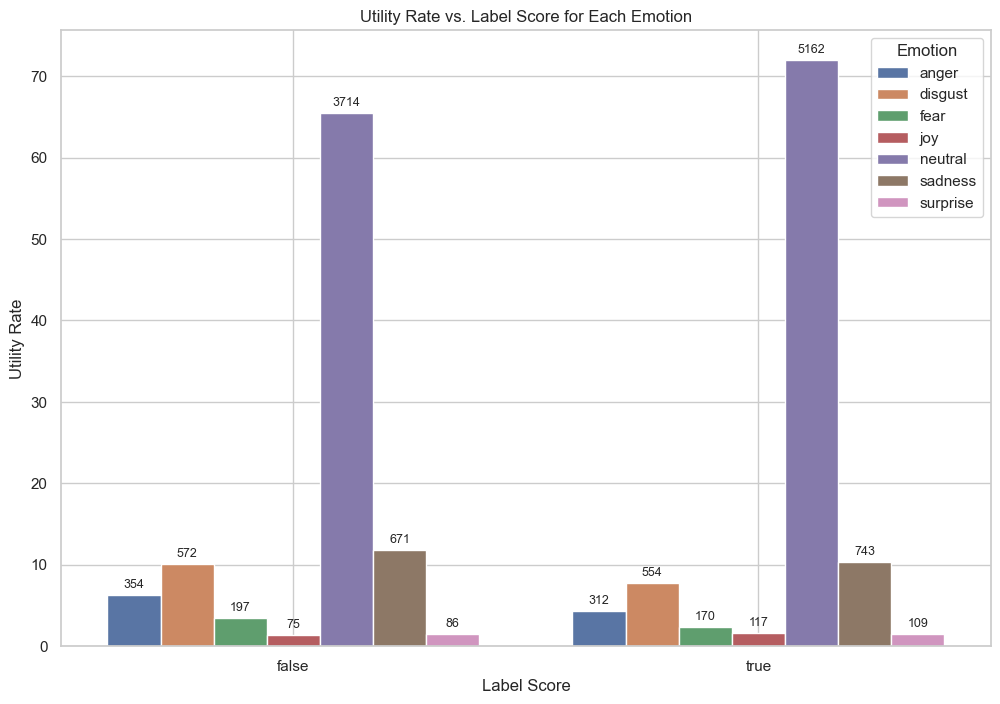

In [32]:
emotion_df = df.groupby(['emotion', 'bin_label']).size().reset_index(name='count')
num_of_labels = df.groupby('bin_label').size()

emotion_df["num_of_labels"] = emotion_df["bin_label"].map(num_of_labels)
emotion_df["utility_rate"] = emotion_df["count"] / emotion_df["num_of_labels"] * 100
#print(emotion_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.barplot(x="bin_label", y="utility_rate", hue="emotion", data=emotion_df)

# Dodawanie wartości pionowo i jako 'count'
for i, bar in enumerate(ax.patches):
    if emotion_df.shape[0] <= i:
        break
    height = bar.get_height()
    # Pobierz odpowiadający count z DataFrame
    count = emotion_df.iloc[i]["count"]
    
    if height > 0:
        ax.annotate(
            str(count),
            (bar.get_x() + bar.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=9,
            xytext=(0, 3),
            textcoords='offset points'
        )

plt.title('Utility Rate vs. Label Score for Each Emotion')
plt.xlabel('Label Score')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

# From the above data, we can conclude that the column "emotion" is useful for predicting the label of the statement. True statements are more neutral.

In [53]:
u = df.groupby('label').size().to_dict()
u

{'barely-true': 2108,
 'false': 2511,
 'half-true': 2638,
 'mostly-true': 2466,
 'pants-fire': 1050,
 'true': 2063}

In [40]:
gibberish_df = df.groupby(['gibberish', 'label']).size().reset_index(name='count')
gibberish_df

,gibberish,label,count
0,clean,barely-true,1736
1,clean,false,2047
2,clean,half-true,2187
3,clean,mostly-true,2095
4,clean,pants-fire,852
5,clean,true,1752
6,mild gibberish,barely-true,370
7,mild gibberish,false,440
8,mild gibberish,half-true,437
9,mild gibberish,mostly-true,369


In [59]:
gibberish_df['num_of_labels'] = gibberish_df["label"].map(u)
gibberish_df

,gibberish,label,count,num_of_labels,utility_rate
0,clean,barely-true,1736,2108,82.352941
1,clean,false,2047,2511,81.521306
2,clean,half-true,2187,2638,82.903715
3,clean,mostly-true,2095,2466,84.955393
4,clean,pants-fire,852,1050,81.142857
5,clean,true,1752,2063,84.924867
6,mild gibberish,barely-true,370,2108,17.552182
7,mild gibberish,false,440,2511,17.522899
8,mild gibberish,half-true,437,2638,16.565580
9,mild gibberish,mostly-true,369,2466,14.963504


In [61]:
gibberish_df["utility_rate"] = gibberish_df["count"] / gibberish_df["num_of_labels"] * 100
gibberish_df

,gibberish,label,count,num_of_labels,utility_rate
0,clean,barely-true,1736,2108,82.352941
1,clean,false,2047,2511,81.521306
2,clean,half-true,2187,2638,82.903715
3,clean,mostly-true,2095,2466,84.955393
4,clean,pants-fire,852,1050,81.142857
5,clean,true,1752,2063,84.924867
6,mild gibberish,barely-true,370,2108,17.552182
7,mild gibberish,false,440,2511,17.522899
8,mild gibberish,half-true,437,2638,16.565580
9,mild gibberish,mostly-true,369,2466,14.963504


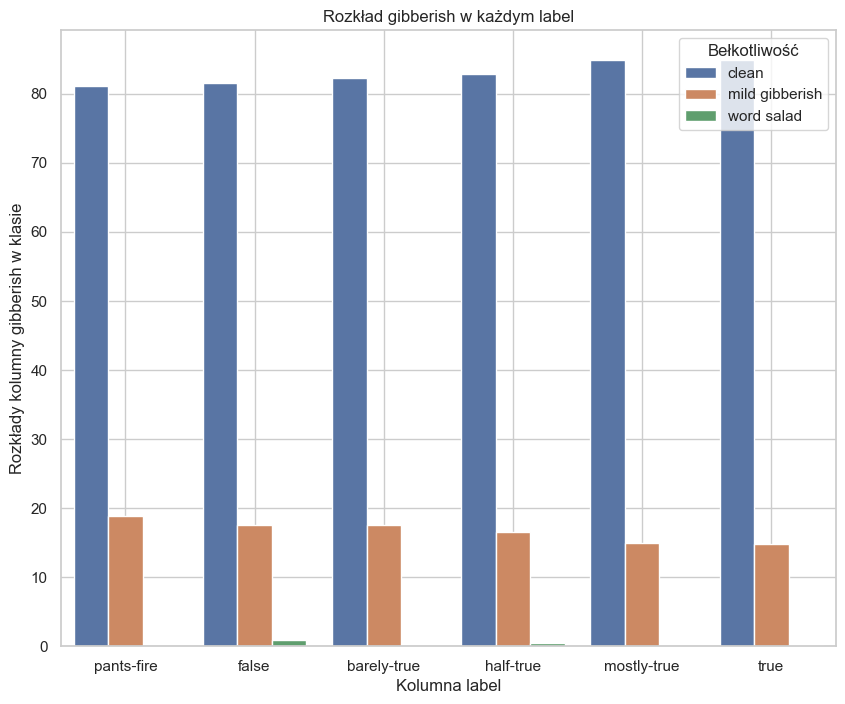

In [65]:
gibberish_df = df.groupby(['gibberish', 'label']).size().reset_index(name='count')
num_of_labels = df.groupby('label').size().to_dict()
gibberish_df["num_of_labels"] = gibberish_df["label"].map(num_of_labels)
gibberish_df["utility_rate"] = gibberish_df["count"] / gibberish_df["num_of_labels"] * 100

#print(gibberish_df)

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.barplot(x="label", y="utility_rate", hue="gibberish", data=gibberish_df, order=custom_order)

plt.title('Rozkład gibberish w każdym label')
plt.xlabel('Kolumna label')
plt.ylabel('Rozkłady kolumny gibberish w klasie')
plt.grid(True)
plt.legend(title='Bełkotliwość')

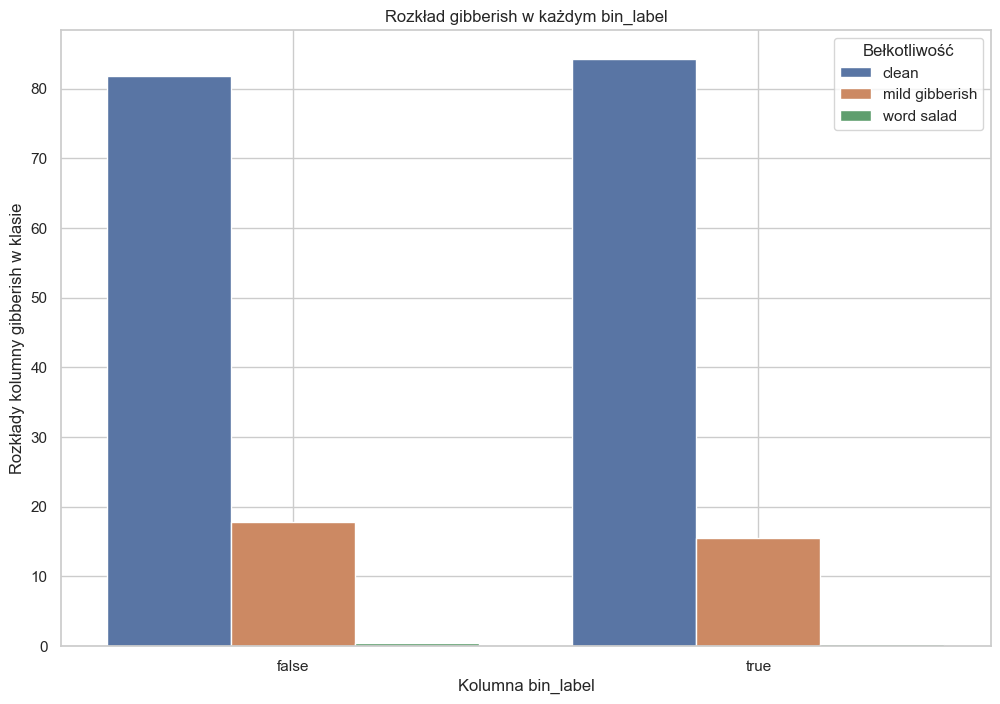

In [68]:
gibberish_df = df.groupby(['gibberish', 'bin_label']).size().reset_index(name='count')
num_of_labels = df.groupby('bin_label').size()
gibberish_df["num_of_labels"] = gibberish_df["bin_label"].map(num_of_labels)
gibberish_df["utility_rate"] = gibberish_df["count"] / gibberish_df["num_of_labels"] * 100

#print(gibberish_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="bin_label", y="utility_rate", hue="gibberish", data=gibberish_df)

plt.title('Rozkład gibberish w każdym bin_label')
plt.xlabel('Kolumna bin_label')
plt.ylabel('Rozkłady kolumny gibberish w klasie')
plt.grid(True)
plt.legend(title='Bełkotliwość')

# From the above data, we can conclude that the column "gibberish" is quite useful for predicting the label of the statement. True statements are less gibberish.

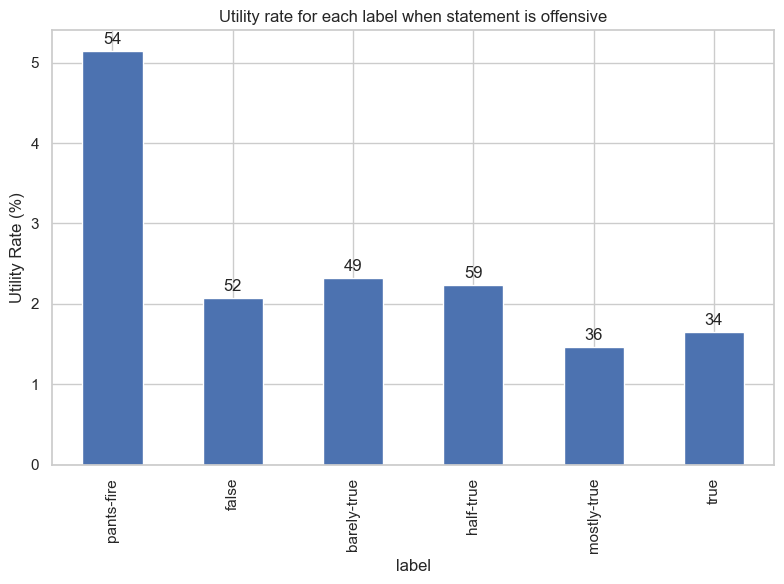

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

custom_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]

# Grupowanie i obliczenia
offensive_df = df.groupby(['offensiveness', 'label']).size().reset_index(name='count')
offensive_df = offensive_df[offensive_df["offensiveness"] == "offensive"]
offensive_df["num_of_labels"] = df.groupby('label').size().values
offensive_df["utility_rate"] = offensive_df["count"] / offensive_df["num_of_labels"] * 100

# Kolejność
offensive_df["label"] = pd.Categorical(offensive_df["label"], categories=custom_order, ordered=True)
offensive_df = offensive_df.sort_values("label")

# Rysowanie wykresu
ax = offensive_df.plot(kind="bar", x='label', y='utility_rate',
                       title="Utility rate for each label when statement is offensive",
                       legend=False, figsize=(8, 6))

# Dodawanie liczby przykładów nad słupkami
for bar, count in zip(ax.patches, offensive_df["count"]):
    height = bar.get_height()
    ax.annotate(f'{count}',  # liczba przykładów
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # przesunięcie tekstu
                textcoords="offset points",
                ha='center', va='bottom')  # obrócenie liczby o 90 stopni

ax.set_ylabel("Utility Rate (%)")
plt.tight_layout()
plt.show()


# From the above data, we can conclude that the column "offensiveness" is useful for predicting the label of the statement. True statements are less offensive. Furthermore, statements that are "pants-fire" are much more offensive that others.

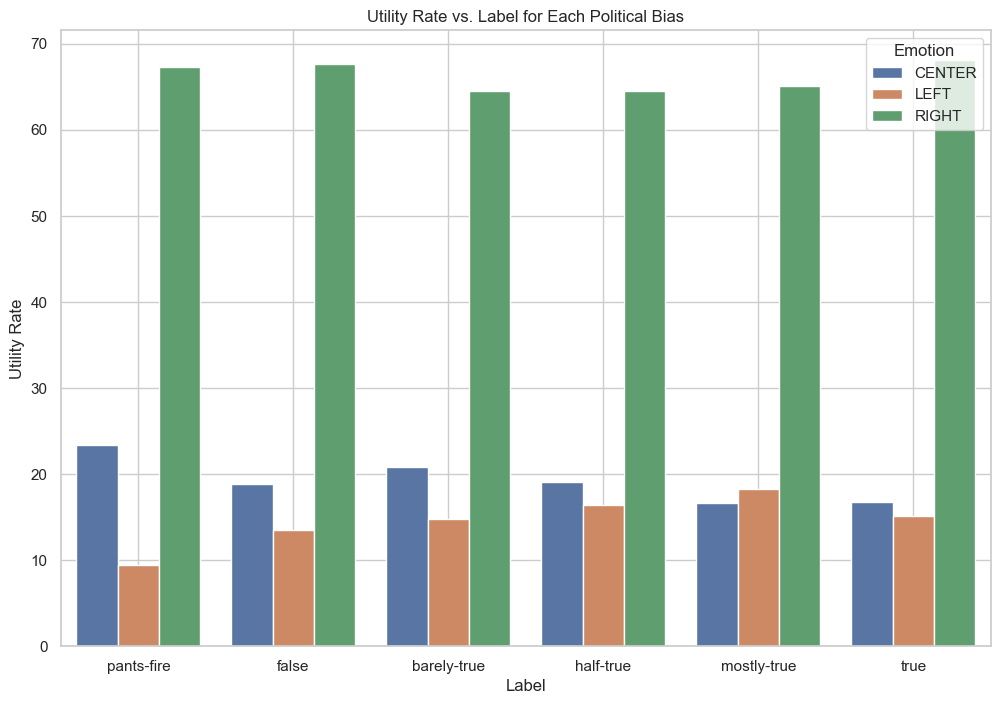

In [69]:
political_bias_df = df.groupby(['political_bias', 'label']).size().reset_index(name='count')
num_of_labels = df.groupby('label').size().to_dict()

political_bias_df["num_of_labels"] = political_bias_df["label"].map(num_of_labels)
political_bias_df["utility_rate"] = political_bias_df["count"] / political_bias_df["num_of_labels"] * 100
#print(political_bias_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="label", y="utility_rate", hue="political_bias", data=political_bias_df, order=custom_order)

plt.title('Utility Rate vs. Label for Each Political Bias')
plt.xlabel('Label')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

  political_bias bin_label  count  num_of_labels  utility_rate
0         CENTER     false   1156           5669     20.391603
1         CENTER      true   1260           7167     17.580578
2           LEFT     false    750           5669     13.229847
3           LEFT      true   1193           7167     16.645737
4          RIGHT     false   3763           5669     66.378550
5          RIGHT      true   4714           7167     65.773685


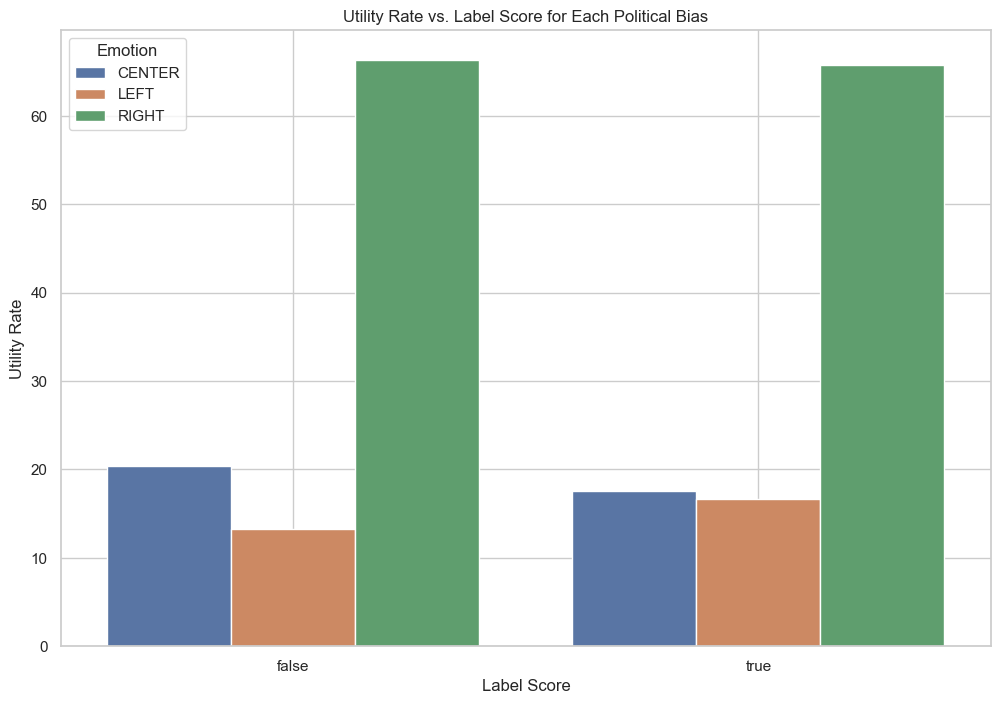

In [38]:
political_bias_df = df.groupby(['political_bias', 'bin_label']).size().reset_index(name='count')
num_of_labels = df.groupby('bin_label').size()

political_bias_df["num_of_labels"] = political_bias_df["bin_label"].map(num_of_labels)
political_bias_df["utility_rate"] = political_bias_df["count"] / political_bias_df["num_of_labels"] * 100
print(political_bias_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="bin_label", y="utility_rate", hue="political_bias", data=political_bias_df)

plt.title('Utility Rate vs. Label Score for Each Political Bias')
plt.xlabel('Label Score')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

# Significance of column "political_bias" for predicting the label of the statement is ambiguous. Statements classified as right wing are majority of statements and the percentage of them don't differ among different labels. Some insight can be gained from sentences classified as centrist or left wing. Generally statements that was classified as centrist are more false, and these classified as left wing are more true. That relationship is more visible in binary classification.